In [1]:
import scipy.io as sio
import numpy as np
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, Flatten
from keras.optimizers import RMSprop
from keras import regularizers
import matplotlib.pyplot as plt
#import seaborn as sns; sns.set()
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from keras import regularizers
from numpy import linalg as LA
from sklearn.model_selection import train_test_split
 #Initial the weight of the network
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)


Using TensorFlow backend.


In [8]:
#loading data
# DDataFile = './3_20_data/qd_LOS_32_3GPPUMi_15k_SC5.mat'
DDataFile = './data/Sim_data/impulses_noreflection.mat'
filename = 'impulses_16'
DData = sio.loadmat(DDataFile)
#get the coeff data
h_coeff_all = DData['h_coeff_real']
location = DData['positions']
index = DData['index']
#split the D_data and location_data and only need the first 2k
N = 1600
M = 16
h_coeff_real = np.array(h_coeff_all[:M,:N])
# print(h_coeff_real[0])
h_coeff_img = np.array(h_coeff_all[M:,:N])
# print(h_coeff_img[0])
h_coeff = h_coeff_real + 1j*h_coeff_img
print("h_coeff.shape ",h_coeff.shape)

loc = np.transpose(location[:,:N])
print("h_coeff shape", h_coeff.shape)
print("loc shape", loc.shape)
print(type(h_coeff))


h_coeff.shape  (16, 1600)
h_coeff shape (16, 1600)
loc shape (1600, 2)
<class 'numpy.ndarray'>


In [13]:
# a = np.array(range(0,20,2)) / 10. # a = 0.5 is the best
a = 0.5
parameter = [10,20,30,50,100,200,500]
err_min = np.zeros(len(parameter))
err_max = np.zeros(len(parameter))
err_avg = np.zeros(len(parameter))
err_var = np.zeros(len(parameter))
loss = np.zeros(len(parameter))

for i in range(len(parameter)):
    seed(1)
    set_random_seed(2)
    D = np.asmatrix(np.fft.fft(np.eye(M)/np.sqrt(M)))
    DH = D.H
    F = np.zeros([N, M * M], dtype = "complex_")
    for j in range(N):
        h = np.asmatrix(h_coeff[:, j:j+1])
        v = (M **(1/(2*a)) / (LA.norm(h, 2) **(1+(1/(2*a))))) * h # a = 0.5 is the best
        KK = v * v.H
        B = D * KK * DH
        F[j] =B.flatten().A
    F = np.asarray(F)
    #Do normalization here for features !!! 
    # Using std to normalize
    # F = F - np.mean(F, axis = 0)
    F = F / np.std(F, axis = 0)
    
    print(F.shape)
    #***************************************************************************************************
    # ft = np.real(F)
    # ft = np.imag(F)
    ft = np.absolute(F) # get the absolute of the F data rel and imaginary part seperately 
    # Split the data
    impulses_train, impulses_test, location_train, location_test = train_test_split(ft, loc, test_size=0.2, random_state=42)
    print(impulses_train.shape)
    #***************************************************************************************************
    #Build the model
    model = keras.Sequential()

    model.add(keras.layers.normalization.BatchNormalization())
    model.add(Dense(11, activation = 'tanh')) #tanh, relu

    # model.add(Dense(8, activation = 'tanh')) #tanh, relu

    model.add(Dense(d, activation = 'linear'))  # None is different from 'linear'      ### the output layer
    #***************************************************************************************************

    #Compilation
    def huber_loss(y_true, y_pred):
        return tf.losses.huber_loss(y_true,y_pred)

    loss_func = huber_loss#"mean_squared_error"   #   categorical_crossentropy(bad)   mean_squared_error  huber_loss
    opt_func = keras.optimizers.Adam(lr=0.001) #'Adam'  lr=0.001  #  RMSprop() sgd()  Adadelta()   Adam  nadam
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=0, mode='auto', baseline=None)]

    model.compile(loss = loss_func, 
                  optimizer = opt_func
                 )
    #***************************************************************************************************

    #Train the model, iterating
    history = model.fit(impulses_train, location_train,
                    batch_size = 20, # 50 -> 52138; 20->52088
                    epochs = 100,
                    verbose = 1,
                    callbacks=callbacks,
                    validation_split = 0.2 #0.2,
#                     validation_data=(impulses_test,location_test)
                   )
    #***************************************************************************************************
    loc_prediction = model.predict(impulses_test)
    loss[i] = model.evaluate(impulses_test, location_test,verbose=0)
    #***************************************************************************************************
    err = loc_prediction - location_test
    x = err[:,:1]
    y = err[:,1:]
    err_dis = np.sqrt(np.square(x)+np.square(y))
    err_min[i] = np.min(err_dis)
    err_max[i] = np.max(err_dis)
    err_avg[i] = np.mean(err_dis)
    err_var[i] = np.var(err_dis)
    print("mean error", err_avg[i])
    #***************************************************************************************************
# print("mean error distance is ", err_avg)
# print("max error distance is ", err_max)
# print("min error distance is ", err_min)
# print("The variance of the distance is ", err_var)

plt.plot(err_avg, label="err_avg")
plt.plot(err_max, label="err_max")
plt.plot(err_min, label="err_min")
plt.plot(err_var, label="err_var")
plt.legend()

(1600, 256)
(1280, 256)
Train on 1024 samples, validate on 256 samples
Epoch 1/100


InvalidArgumentError: Incompatible shapes: [20,1600] vs. [20,2]
	 [[Node: training_6/Adam/gradients/loss_6/dense_14_loss/huber_loss/Sub_grad/BroadcastGradientArgs = BroadcastGradientArgs[T=DT_INT32, _class=["loc:@training_6/Adam/gradients/loss_6/dense_14_loss/huber_loss/Sub_grad/Reshape"], _device="/job:localhost/replica:0/task:0/device:CPU:0"](training_6/Adam/gradients/loss_6/dense_14_loss/huber_loss/Sub_grad/Shape, training_6/Adam/gradients/loss_6/dense_14_loss/huber_loss/Sub_grad/Shape_1)]]

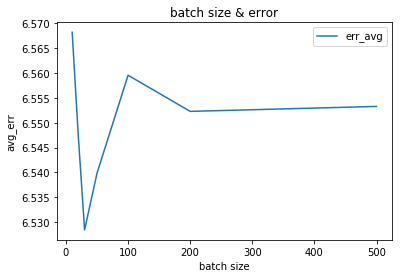

In [67]:
plt.plot(parameter,err_avg, label="err_avg")
# plt.plot(err_max, label="err_max")
# plt.plot(err_min, label="err_min")
# plt.plot(err_var, label="err_var")
plt.ylabel('avg_err')
plt.xlabel('batch size')
plt.title("batch size & error")
plt.legend()
plt.savefig("a_change.png")